#### Setup: Dependencies, Constants, and Seeding

This notebook uses a genetic algorithm that solves a TSP with 100 cities
that is imported from an internal module

In [1]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np

In [2]:
sys.path.append(os.getcwd())
from genetic_algorithm import genetic_algorithm

In [3]:
SEED = 42  # To reproduce
N_RUNS = 10  # Independent Runs
EVAL_BUDGET = 500  # Budget to evaluate the true value of a result
SIM_BUDGET = 5000  # Budget for simulation

## 1. Genetic Algorithm (GA)

Repeatedly simulates a random configuration for the Genetic Algorithm. 

In [4]:
results = []
num_evaluations = 1000

for i in range(num_evaluations):
    r = genetic_algorithm(
        crossover_rate=0.500,
        mutation_rate=0.001,
        elite_size=10,
        population_size=50,
        generations=300,
        seed=i,
    )
    results.append(r)

Distribution of best tour distance

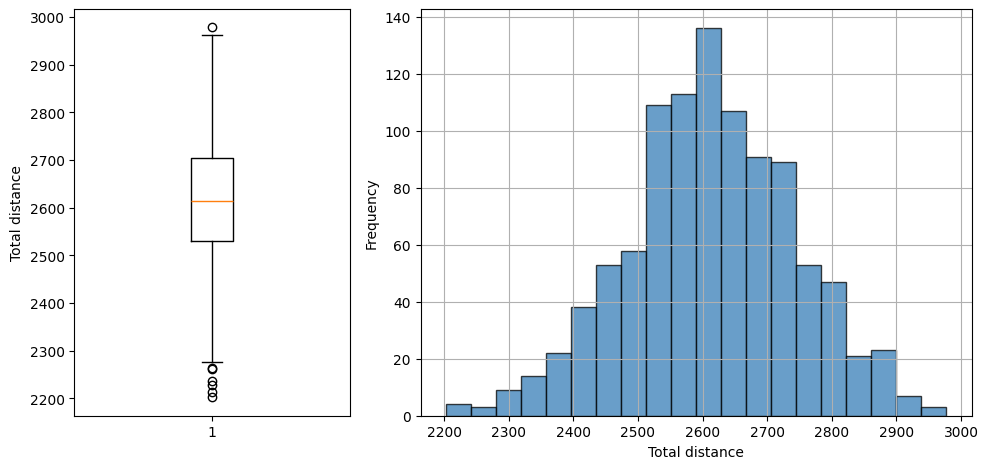

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios": [1, 2]})

# Boxplot on the left (1/3 width)
axes[0].boxplot(results)
axes[0].set_ylabel("Total distance")
axes[0].grid(False)

# Histogram on the right (2/3 width)
axes[1].hist(results, bins=20, edgecolor="black", color=["#377eb8"], alpha=0.75)
axes[1].set_xlabel("Total distance")
axes[1].set_ylabel("Frequency")
axes[1].grid()

plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

Stability of the mean of the best tour length

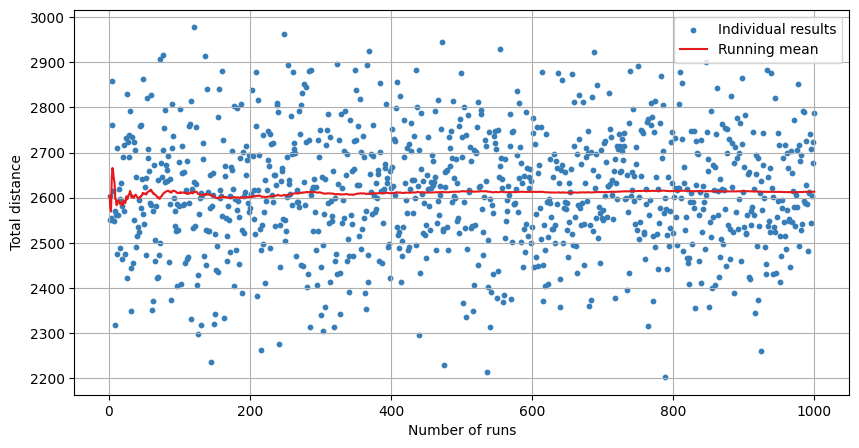

In [8]:
# Compute the running_means
results_index = np.arange(1, num_evaluations + 1)
running_means = np.cumsum(results) / (results_index)

# Scatter the individual results and plot the running_means
plt.figure(figsize=(10, 5))
plt.scatter(results_index, results, label="Individual results", color="#377eb8", s=10)
plt.plot(results_index, running_means, label="Running mean", color="#e41a1c")
plt.xlabel("Number of runs")
plt.ylabel("Total distance")
plt.grid()
plt.legend()
plt.show()

## 2. Optimization

### 2.1 Parameter Space

Same solution space for each optimizer to ensure fair comparison

#### 2.1.1 Generations 

No optimization of generations (more is always better, see example for one configuration)

In [9]:
results = []
generations = list(range(50, 501, 50))

for gen in generations:
    r = [
        genetic_algorithm(
            crossover_rate=0.500,
            mutation_rate=0.001,
            elite_size=10,
            population_size=50,
            generations=gen,
            seed=i,
        )
        for i in range(EVAL_BUDGET)
    ]
    results.append(r)

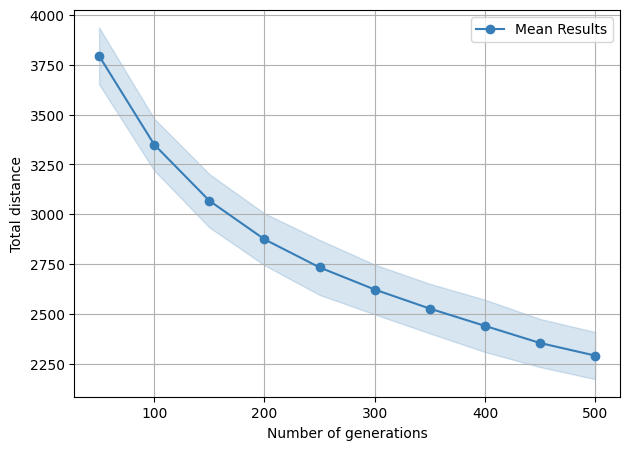

In [17]:
# Plot mean results for each generation
means = np.array([np.mean(r) for r in results])
plt.plot(generations, means, label="Mean Results", marker="o", color="#377eb8")

# Estimate the range by plotting the std deviation
sd = np.array([np.std(r) for r in results])
plt.fill_between(generations, means - sd, means + sd, alpha=0.2, color="#377eb8")

plt.ylabel("Total distance")
plt.xlabel("Number of generations")
plt.grid(True)
plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.legend()
plt.show()

#### Population and Elitist Selection
- Determines size of the population, and if population is selected based on elitism or roulette wheel selection.
- A larger elite_size compared to population_size does not raise an error and has the effect of elite_size == population_size

In [ ]:
population_size = list(range(20, 101, 10))
len(population_size)

9

In [ ]:
elite_size = list(range(0, 101, 10))
len(elite_size)

11

#### Mutation Rate

Modeling mutation rate effects on tours using an exponential (log-scale) relationship rather than a linear one is more accurate, because the probability of a tour being mutated grows nonlinearly with mutation rate. In particular, even a small increase in the per-city mutation rate rapidly increases the likelihood that at least one city in a tour is altered, due to the compounding effect across all cities. Thus, a log-scaled view better captures the true sensitivity and threshold behavior of mutation impact in evolutionary dynamics.

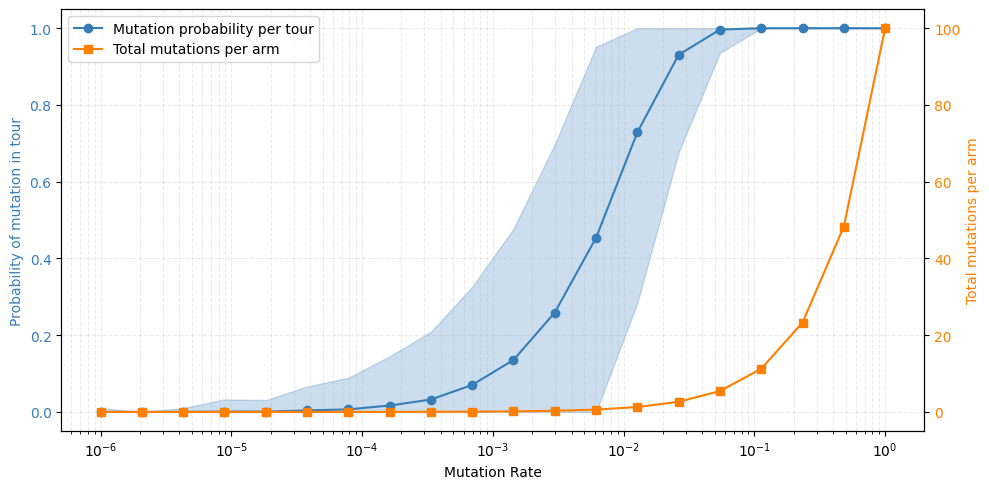

In [15]:
n_cities = 100
n_experiments = 10000
SEED = 42
rng = np.random.default_rng(SEED)
mutation_rate = np.logspace(-6, 0, 20)

mean_cnt = []
mean_prob = []
stds_prob = []
for idx, mr in enumerate(mutation_rate):
    # Simulate the number of mutations per tour
    mut = rng.random((n_experiments, n_cities)) < mr
    mut_cnt = mut.sum(axis=1)

    # Track the mean number of mutations
    mean_cnt.append(np.mean(mut_cnt))

    # Track the number of times a tour has been modified
    mean_prob.append(np.mean(mut_cnt > 0))
    stds_prob.append(np.std(mut_cnt > 0))


fix, ax_left = plt.subplots(figsize=(10, 5))
ax_right = ax_left.twinx()

# Primary axis: mutation probability per tour
line1 = ax_left.plot(
    mutation_rate,
    mean_prob,
    color="#377eb8",
    marker="o",
    label="Mutation probability per tour",
)

lower = np.clip(np.array(mean_prob) - np.array(stds_prob), 0.0, 1.0)
upper = np.clip(np.array(mean_prob) + np.array(stds_prob), 0.0, 1.0)
ax_left.fill_between(
    mutation_rate, lower, upper, color="#377eb8", label="Standard Deviation", alpha=0.25
)

ax_left.set_ylabel("Probability of mutation in tour", color="#377eb8")
ax_left.tick_params(axis="y", labelcolor="#377eb8")
ax_left.set_xscale("log")
ax_left.set_xlabel("Mutation Rate")
ax_left.grid(True, which="both", ls="--", alpha=0.25)

# Secondary axis: Number of mutations per tour
line2 = ax_right.plot(
    mutation_rate,
    mean_cnt,
    marker="s",
    color="#ff7f00",
    label="Total mutations per arm",
)
ax_right.set_ylabel("Total mutations per arm", color="#ff7f00")
ax_right.tick_params(axis="y", labelcolor="#ff7f00")

lines = line1 + line2
labels = [line.get_label() for line in lines]
ax_left.legend(lines, labels, loc="upper left")

plt.tight_layout()
plt.show()

In [21]:
mutation_rate = np.logspace(-6, 0, 20).tolist()
print(len(mutation_rate))

20


#### Crossover Rate

In [14]:
crossover_rate = np.round(np.arange(0.0, 1.01, 0.05), 2).tolist()
len(crossover_rate)

21

### 2.2 Optimization with EvoBandits

#### 2.3 Optimization with irace

## 3. Comparison

In [6]:
["#377eb8", "#ff7f00", "#4daf4a", "#e41a1c", "#984ea3"]

['#377eb8', '#ff7f00', '#4daf4a', '#e41a1c', '#984ea3']